<a href="https://colab.research.google.com/github/vedant75/AlgosFromScratch/blob/main/Housing_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sukhmandeepsinghbrar/housing-price-dataset")

print("Path to dataset files:", path)

100%|██████████| 780k/780k [00:00<00:00, 58.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sukhmandeepsinghbrar/housing-price-dataset/versions/1


In [3]:
# Construct the full path to the CSV file
csv_path = path + "/Housing.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7229300521,20141013T000000,231300.0,2,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
df.isna().sum()

,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df.dtypes

,0
id,int64
date,datetime64[ns]
price,float64
bedrooms,int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64


In [36]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [9]:
print("\nNumerical features statistics:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols].describe()


Numerical features statistics:


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580306e+09,5.400886e+05,3.370795,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876570e+09,3.671268e+05,0.930105,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [10]:
print("\nCategorical features distribution:")
categorical_cols = df.select_dtypes(include=[object]).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())

# Check for multicollinearity in numerical features
print(f"\n MULTICOLLINEARITY ANALYSIS")
print("-" * 40)
correlation_matrix = df[numerical_cols].corr()
print("Correlation matrix for numerical features:")
correlation_matrix.round(3)


Categorical features distribution:

 MULTICOLLINEARITY ANALYSIS
----------------------------------------
Correlation matrix for numerical features:


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000,-0.017,0.001,0.005,-0.012,-0.132,0.019,-0.003,0.012,-0.024,0.008,-0.011,-0.005,0.021,-0.017,-0.008,-0.002,0.021,-0.003,-0.139
price,-0.017,1.000,0.308,0.525,0.702,0.090,0.257,0.266,0.397,0.036,0.667,0.606,0.324,0.054,0.126,-0.053,0.307,0.022,0.585,0.082
bedrooms,0.001,0.308,1.000,0.516,0.577,0.032,0.175,-0.007,0.080,0.029,0.357,0.478,0.303,0.154,0.019,-0.153,-0.009,0.129,0.392,0.029
bathrooms,0.005,0.525,0.516,1.000,0.755,0.088,0.501,0.064,0.188,-0.125,0.665,0.685,0.284,0.506,0.051,-0.204,0.025,0.223,0.569,0.087
sqft_living,-0.012,0.702,0.577,0.755,1.000,0.173,0.354,0.104,0.285,-0.059,0.763,0.877,0.435,0.318,0.055,-0.199,0.053,0.240,0.756,0.183
sqft_lot,-0.132,0.090,0.032,0.088,0.173,1.000,-0.005,0.022,0.075,-0.009,0.114,0.184,0.015,0.053,0.008,-0.130,-0.086,0.230,0.145,0.719
floors,0.019,0.257,0.175,0.501,0.354,-0.005,1.000,0.024,0.029,-0.264,0.458,0.524,-0.246,0.489,0.006,-0.059,0.050,0.125,0.280,-0.011
waterfront,-0.003,0.266,-0.007,0.064,0.104,0.022,0.024,1.000,0.402,0.017,0.083,0.072,0.081,-0.026,0.093,0.030,-0.014,-0.042,0.086,0.031
view,0.012,0.397,0.080,0.188,0.285,0.075,0.029,0.402,1.000,0.046,0.251,0.168,0.277,-0.053,0.104,0.085,0.006,-0.078,0.280,0.073
condition,-0.024,0.036,0.029,-0.125,-0.059,-0.009,-0.264,0.017,0.046,1.000,-0.145,-0.158,0.174,-0.361,-0.061,0.003,-0.015,-0.107,-0.093,-0.003


In [11]:
# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > 0.7:  # High correlation threshold
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val)
            high_corr_pairs.append(pair)

high_corr_pairs

[('price', 'sqft_living', np.float64(0.7020346040056639)),
 ('bathrooms', 'sqft_living', np.float64(0.7546652789673752)),
 ('sqft_living', 'grade', np.float64(0.7627044764584776)),
 ('sqft_living', 'sqft_above', np.float64(0.8765965986813202)),
 ('sqft_living', 'sqft_living15', np.float64(0.7564202590172237)),
 ('sqft_lot', 'sqft_lot15', np.float64(0.7185567524330374)),
 ('grade', 'sqft_above', np.float64(0.755922937623647)),
 ('grade', 'sqft_living15', np.float64(0.7132020930151698)),
 ('sqft_above', 'sqft_living15', np.float64(0.7318702923539875))]

In [16]:
if high_corr_pairs:
    print(f"\n High correlation pairs (r > 0.7) - MULTICOLLINEARITY DETECTED:")
    for col1, col2, corr in high_corr_pairs:
        print(f" {col1} - {col2}: {corr:.3f}")
else:
    print("No severe multicollinearity detected")


 High correlation pairs (r > 0.7) - MULTICOLLINEARITY DETECTED:
 price - sqft_living: 0.702
 bathrooms - sqft_living: 0.755
 sqft_living - grade: 0.763
 sqft_living - sqft_above: 0.877
 sqft_living - sqft_living15: 0.756
 sqft_lot - sqft_lot15: 0.719
 grade - sqft_above: 0.756
 grade - sqft_living15: 0.713
 sqft_above - sqft_living15: 0.732


In [17]:
# Check price distribution skewness
price_skewness = stats.skew(df['price'])
print(f"Price skewness: {price_skewness:.3f}")
if abs(price_skewness) > 0.5:
    print("Price distribution is skewed - consider log transformation")

Price skewness: 4.024
Price distribution is skewed - consider log transformation


In [18]:
# Correlations with target variable
print(f"\n FEATURE CORRELATIONS WITH PRICE")
print("-" * 40)
price_correlations = df[numerical_cols].corr()['price'].sort_values(ascending=False)
print("Features ranked by correlation with price:")
for feature, corr in price_correlations.items():
    if feature != 'price':
        print(f"  {feature:<15}: {corr:6.3f}")


 FEATURE CORRELATIONS WITH PRICE
----------------------------------------
Features ranked by correlation with price:
  sqft_living    :  0.702
  grade          :  0.667
  sqft_above     :  0.606
  sqft_living15  :  0.585
  bathrooms      :  0.525
  view           :  0.397
  sqft_basement  :  0.324
  bedrooms       :  0.308
  lat            :  0.307
  waterfront     :  0.266
  floors         :  0.257
  yr_renovated   :  0.126
  sqft_lot       :  0.090
  sqft_lot15     :  0.082
  yr_built       :  0.054
  condition      :  0.036
  long           :  0.022
  id             : -0.017
  zipcode        : -0.053


In [19]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [20]:
df1 = df.copy()

In [23]:
# df1.bedrooms.unique(), df1.bathrooms.unique()

(array([ 2,  3,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33]),
 array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
        3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 0.  , 1.25, 5.25, 6.  , 0.5 ,
        5.5 , 6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ]))

In [24]:
# One-hot encode categorical columns
features_to_encode = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
df_encoded = pd.get_dummies(df1[features_to_encode], drop_first=True)
df1 = pd.concat([df1.drop(features_to_encode, axis=1), df_encoded], axis=1)

In [25]:
# Apply log transformation to the price column
df1['price'] = np.log1p(df1['price'])

In [26]:
# Define features (X) and target (y)
X = df1.drop(['price', 'id', 'date'], axis=1)
y = df1['price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

lasso = Lasso(alpha=1000)  # Try alpha=0.1, 0.01, etc. later
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)


MSE: 0.28267081185545395


In [28]:
selected_features = X.columns[lasso.coef_ != 0]
print("Selected features by LASSO:")
print(selected_features)


Selected features by LASSO:
Index(['sqft_lot'], dtype='object')


In [29]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha:", lasso_cv.alpha_)


Best alpha: 2.038009075307401


In [30]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# MSE scorer (negative because sklearn wants higher = better)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)


In [31]:
# Model 1: Linear Regression (alpha = 0)
lr = LinearRegression()
mse_lr = cross_val_score(lr, X, y, cv=kf, scoring=mse_scorer)

# Model 2: LASSO with alpha ≈ 2
lasso = Lasso(alpha=2.04)
mse_lasso = cross_val_score(lasso, X, y, cv=kf, scoring=mse_scorer)


In [32]:
print("Linear Regression (alpha=0) CV MSEs:", -mse_lr)
print("Avg MSE:", -np.mean(mse_lr))

print("\nLASSO (alpha=1) CV MSEs:", -mse_lasso)
print("Avg MSE:", -np.mean(mse_lasso))


Linear Regression (alpha=0) CV MSEs: [0.06527777 0.06270216 0.06264381 0.06327531 0.06550771]
Avg MSE: 0.06388135192667188

LASSO (alpha=1) CV MSEs: [0.1335922  0.13313907 0.12959289 0.12995824 0.13492423]
Avg MSE: 0.13224132453296594


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def forward_feature_selection(X, y, model, cv=5, scoring='r2'):
    selected_features = []
    remaining_features = list(X.columns)
    best_cv_score = -np.inf  # higher is better for R2

    while remaining_features:
        scores = []
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            X_subset = X[features_to_try]

            cv_score = cross_val_score(model, X_subset, y, cv=cv, scoring=scoring).mean()
            scores.append((cv_score, feature))

        scores.sort(reverse=True)
        best_new_score, best_new_feature = scores[0]

        if best_new_score <= best_cv_score:
            break

        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        best_cv_score = best_new_score
        print(f"Added {best_new_feature}, CV {scoring} = {best_new_score:.4f}")

    return selected_features

# Example usage:
model = LinearRegression()
selected = forward_feature_selection(X_train, y_train, model, scoring='r2')
print("Selected features:", selected)


Added grade, CV r2 = 0.4902
Added lat, CV r2 = 0.6292
Added sqft_living, CV r2 = 0.7025
Added yr_built, CV r2 = 0.7316
Added view, CV r2 = 0.7452
Added bathrooms, CV r2 = 0.7507
Added sqft_living15, CV r2 = 0.7557
Added condition, CV r2 = 0.7596
Added waterfront, CV r2 = 0.7630
Added floors, CV r2 = 0.7659
Added zipcode, CV r2 = 0.7677
Added long, CV r2 = 0.7682
Added yr_renovated, CV r2 = 0.7688
Added sqft_lot, CV r2 = 0.7692
Added bedrooms, CV r2 = 0.7694
Added sqft_above, CV r2 = 0.7694
Added sqft_basement, CV r2 = 0.7694
Selected features: ['grade', 'lat', 'sqft_living', 'yr_built', 'view', 'bathrooms', 'sqft_living15', 'condition', 'waterfront', 'floors', 'zipcode', 'long', 'yr_renovated', 'sqft_lot', 'bedrooms', 'sqft_above', 'sqft_basement']


# Approach 2: NN

In [38]:
# --- Configuration ---
TARGET = 'price'
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Load data
df1 = df.copy()

In [63]:
# 1. Feature Engineering: Convert 'date'
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# 2. Define Features (X) and Target (y)
# Drop the target, the original date, and the unusable id
X = df.drop([TARGET, 'date', 'id'], axis=1)
y = df[TARGET]
y_log = np.log(y + 1)

In [79]:
# 3. Define Numerical and Categorical Features
# 'zipcode' is categorical
categorical_features = ['zipcode']

# All other columns are numerical
numerical_features = [col for col in X.columns if col not in categorical_features]

# 4. Create the Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any columns not listed (though we've used all)
)

# 5. Split and Process Data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

# Get the number of input features *after* one-hot encoding
# This is CRITICAL for building the network's first layer
input_dim = X_train_processed.shape[1]
print(f"Original features: {len(X.columns)}, Processed features (after OHE): {input_dim}")

Original features: 21, Processed features (after OHE): 90


In [80]:
# --- Step 2: Convert Data to PyTorch Tensors & Create DataLoaders ---

# Convert numpy arrays to PyTorch Tensors
# We need to reshape 'y' to be a column vector [n_samples, 1]
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_raw.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_raw.values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batching
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [85]:
class RegressionNet(nn.Module):
    def __init__(self, input_features):
        super(RegressionNet, self).__init__()

        self.fc1 = nn.Linear(input_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

        # Define a dropout layer
        # p=0.5 means 50% of neurons will be "dropped" during training
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = self.dropout(x)  # <-- ADD DROPOUT AFTER ACTIVATION

        x = F.tanh(self.fc2(x))
        x = self.dropout(x)  # <-- ADD DROPOUT AFTER ACTIVATION

        x = self.out(x)
        return x

# --- Step 4: Initialize Model, Loss, and Optimizer ---

# Create an instance of the model
# 'input_dim' is the calculated number of features after processing
model = RegressionNet(input_features=input_dim)

# Define the Loss Function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Define the Optimizer (Adam is a great default)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [86]:
# --- Step 5: The Training Loop ---
print("\nStarting training...")
for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode

    for batch_X, batch_y in train_loader:
        # 1. Clear old gradients
        optimizer.zero_grad()

        # 2. Forward pass: make predictions
        outputs = model(batch_X)

        # 3. Calculate the loss
        loss = criterion(outputs, batch_y)

        # 4. Backward pass: calculate gradients
        loss.backward()

        # 5. Update weights
        optimizer.step()

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        # We calculate Root Mean Squared Error (RMSE) for easier interpretation
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, RMSE: {torch.sqrt(loss).item():.2f}')

print("Training finished!")


Starting training...
Epoch [5/50], Loss: 3.0572, RMSE: 1.75
Epoch [10/50], Loss: 2.0268, RMSE: 1.42
Epoch [15/50], Loss: 2.1330, RMSE: 1.46
Epoch [20/50], Loss: 1.9425, RMSE: 1.39
Epoch [25/50], Loss: 1.0871, RMSE: 1.04
Epoch [30/50], Loss: 1.4673, RMSE: 1.21
Epoch [35/50], Loss: 1.0122, RMSE: 1.01
Epoch [40/50], Loss: 2.2542, RMSE: 1.50
Epoch [45/50], Loss: 1.8617, RMSE: 1.36
Epoch [50/50], Loss: 0.3526, RMSE: 0.59
Training finished!


In [87]:
model.eval()
with torch.no_grad():
    all_outputs_orig = []
    all_labels_orig = []

    for batch_X, batch_y_log in test_loader:
        # 1. Get model predictions (still in log-space)
        outputs_log = model(batch_X)

        # 2. Convert BOTH predictions AND labels back to dollars
        # We use torch.exp() which is the inverse of torch.log()
        # (We add 1 and subtract 1 to reverse the np.log(y + 1) transform)
        outputs_orig = torch.exp(outputs_log) - 1
        labels_orig = torch.exp(batch_y_log) - 1

        # 3. Store them
        all_outputs_orig.append(outputs_orig)
        all_labels_orig.append(labels_orig)

    # Concatenate all batches into single tensors
    all_outputs_orig = torch.cat(all_outputs_orig)
    all_labels_orig = torch.cat(all_labels_orig)

    # 4. Calculate RMSE on the *original dollar values*
    # Move tensors to CPU and convert to numpy for scikit-learn
    test_rmse = np.sqrt(mean_squared_error(
        all_labels_orig.cpu().numpy(),
        all_outputs_orig.cpu().numpy()
    ))

    print(f'Final Test RMSE (in dollars): {test_rmse:.2f}')

Final Test RMSE (in dollars): 230160.33


# Appendix
## Practice implementing LR

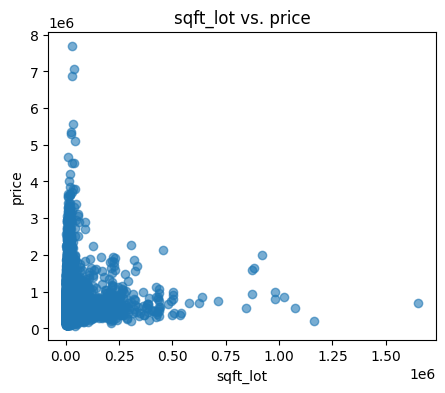

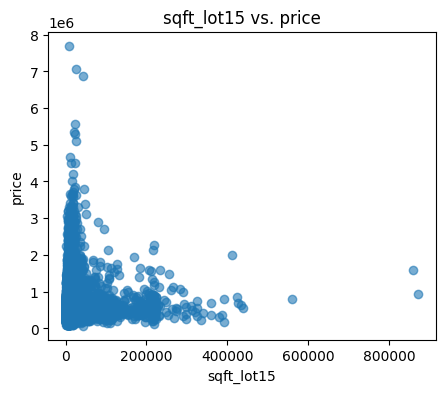

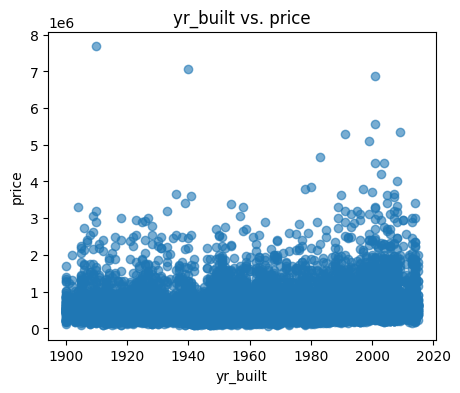

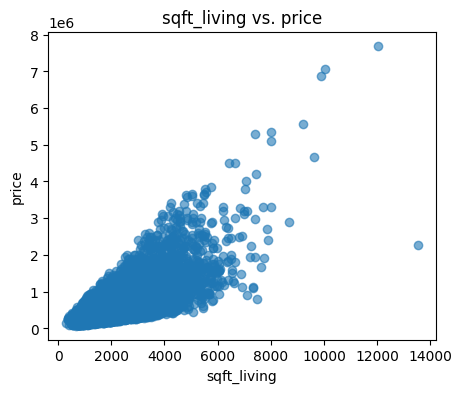

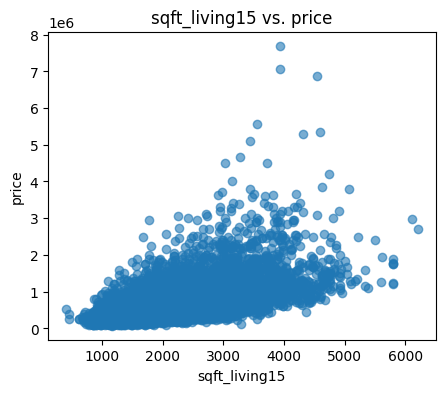

In [ ]:
# 2. Pick a few numeric columns you think matter:
features = ["sqft_lot", "sqft_lot15", "yr_built", "sqft_living", 'sqft_living15']
target   = "price"

# 3. Scatter each vs. target
for feat in features:
    plt.figure(figsize=(5,4))
    plt.scatter(df[feat], df[target], alpha=0.6)
    plt.xlabel(feat)
    plt.ylabel(target)
    plt.title(f"{feat} vs. {target}")
    plt.show()

In [ ]:
df.shape

(21613, 21)

In [ ]:
df1 = df.copy()

In [ ]:
df1.drop(['id', 'date'], axis=1, inplace=True)


In [ ]:
df1 = df1.astype(float)

In [ ]:
# df1.dtypes

In [ ]:
from sklearn.model_selection import train_test_split
target = "price"
X = df1.drop([target], axis=1)
y = df1[target]
# X=df1[["bathrooms","lat","long","sqft_lot15","grade","waterfront","sqft_lot","bedrooms","yr_built","yr_renovated","condition",
#       "view","sqft_living"]]
# y=df1["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17290, 18), (4323, 18), (17290,), (4323,))

In [ ]:
import numpy as np

m, n = X_train.shape

X_train_vals = X_train.values            # shape = (m, n)
m, n = X_train_vals.shape

mu    = np.mean(X_train_vals, axis=0)    # (n,)
sigma = np.std (X_train_vals, axis=0)    # (n,)
sigma[sigma == 0] = 1                # guard against zero‐variance columns

# 3) Normalize X_train → X_norm
X_norm = (X_train - mu) / sigma        # shape: (m, n)

# 4) Build design matrix X_b from X_norm (normalized features!)
X_b = np.hstack([np.ones((m,1)), X_norm])  # shape: (m, n+1)

# 5) Turn y_train into (m,1) column
y_vec = y_train.values.reshape(m, 1)       # shape: (m, 1)

# 6) Initialize theta to zeros (n+1, 1)
theta = np.zeros((n+1, 1))                 # shape: (n+1, 1)

# 7) Hyperparameters
alpha     = 1e-3    # start with 1e-3 after normalization
num_iters = 2000

# 8) (Optional) cost‐function helper, just for monitoring
def compute_cost(X, y, theta):
    errs = X.dot(theta) - y
    return (1/(2*m)) * np.sum(errs**2)

# 9) Gradient descent loop
for it in range(num_iters):
    # a) Predictions:    (m,1) vector
    preds = X_b.dot(theta)

    # b) Errors:         (m,1) vector
    errors = preds - y_vec

    # c) Gradient:       (n+1,1) vector
    grad = (1/m) * (X_b.T.dot(errors))

    # d) Check for Inf/NaN before updating
    if not np.isfinite(grad).all():
        print(f"Iteration {it:4d}: gradient has NaN or Inf; stopping early.")
        break

    # e) Update theta
    theta -= alpha * grad

    # f) (Optional) print cost every 100 iters
    if it % 100 == 0:
        J = compute_cost(X_b, y_vec, theta)
        print(f"Iter {it:4d} | Cost = {J:.6e}")

# 10) After the loop:
print("Final θ (normalized‐feature space):", theta.ravel())


theta: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]],  grad: [[-537768.59161365]
 [-111434.80832872]
 [-190347.01535887]
 [-253631.61130166]
 [ -32906.23947551]
 [ -91600.83338508]
 [ -91428.11920712]
 [-141728.60258825]
 [ -13136.18930857]
 [-240400.01459728]
 [-218048.26265191]
 [-116166.19589553]
 [ -17746.89139425]
 [ -46171.01355333]
 [  19446.28931206]
 [-112328.7640541 ]
 [  -8488.86156127]
 [-210606.51840148]
 [ -28609.75053303]]
[[537.76859161]
 [111.43480833]
 [190.34701536]
 [253.6316113 ]
 [ 32.90623948]
 [ 91.60083339]
 [ 91.42811921]
 [141.72860259]
 [ 13.13618931]
 [240.4000146 ]
 [218.04826265]
 [116.1661959 ]
 [ 17.74689139]
 [ 46.17101355]
 [-19.44628931]
 [112.32876405]
 [  8.48886156]
 [210.6065184 ]
 [ 28.60975053]]
Iter    0 | Cost = 2.093028e+11
theta: [[537.76859161]
 [111.43480833]
 [190.34701536]
 [253.6316113 ]
 [ 32.90623948]
 [ 91.60083339]
 [ 91.42811921]
 [141.72860259]
 [ 13.13618931]
 

In [ ]:
# 1) Convert X_test to a NumPy array (if it isn’t already) and apply the same scaling:
X_test_vals = X_test.values            # shape: (m_test, n)

# Use exactly the same mu, sigma from the TRAINING set:
X_test_norm = (X_test_vals - mu) / sigma   # shape: (m_test, n)

# 2) Build the test design matrix X_b_test by adding a column of 1’s:
m_test = X_test_norm.shape[0]
X_b_test = np.hstack([np.ones((m_test, 1)), X_test_norm])  # shape: (m_test, n+1)

# 3) Compute predictions (shape: (m_test, 1)):
y_pred = X_b_test.dot(theta)          # each row is θᵀ x_test_b^(i)

# y_pred is a (m_test × 1) array of predicted house prices (same units as your original y).
# If you want a flat array instead of a column vector, you can do:
y_pred_flat = y_pred.ravel()         # shape: (m_test,)

# (Optional) 4) Compare to y_test to compute, say, RMSE:
errors = y_pred_flat - y_test.values       # shape: (m_test,)
rmse = np.sqrt(np.mean(errors**2))
print("Test RMSE =", rmse)

Test RMSE = 230316.4963353722
